In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn import metrics
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.grid_search import GridSearchCV

C:\Program Files\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
import matplotlib
import matplotlib.pyplot as plt

In [3]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [4]:
def modelfit(alg, feature_names, X_train, y_train, X_test, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, label=y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])

    #Fit the algorithm on the data
    alg.fit(X_train, y_train)

    #Predict training set:
    y_predictions = alg.predict(X_test)
#     dtrain_predprob = alg.predict_proba(y_test)

    #Print model report:
    print("\nModel Report")
    print("RMSE : %.4g" % metrics.mean_squared_error(y_test, y_predictions))
    #print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))

    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp = feat_imp.rename(lambda x: feature_names[int(x[1:len(x)])])
    
    feat_imp.plot(kind='barh', title='Feature Importances',figsize=(7, 16))
    plt.ylabel('Feature Importance Score')

In [5]:
def ModelParamSearch(xgb, params, X_train, y_train):
    search = GridSearchCV(estimator=xgb, param_grid=params, n_jobs=4, iid=False, cv=5)
    search.fit(X_train, y_train)
    print('\ngrid_scores')
    for score in search.grid_scores_:
        print(score)
    print('\nbest_params')
    print(search.best_params_)
    print('\nbest_score')
    print(search.best_score_)
    return search

In [23]:
X_train_df = pd.read_csv("../data/offline/X_train.csv", index_col=0)
y_train_df = pd.read_csv("../data/offline/y_train.csv", index_col=0)
X_test_df = pd.read_csv("../data/offline/X_test.csv", index_col=0)
combine_df = pd.concat([X_train_df, X_test_df])

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_train_df.values, y_train_df['SalePrice'].values, test_size=0.5, random_state=1729)

In [25]:
feature_names = X_train_df.columns


Model Report
RMSE : 0.02032


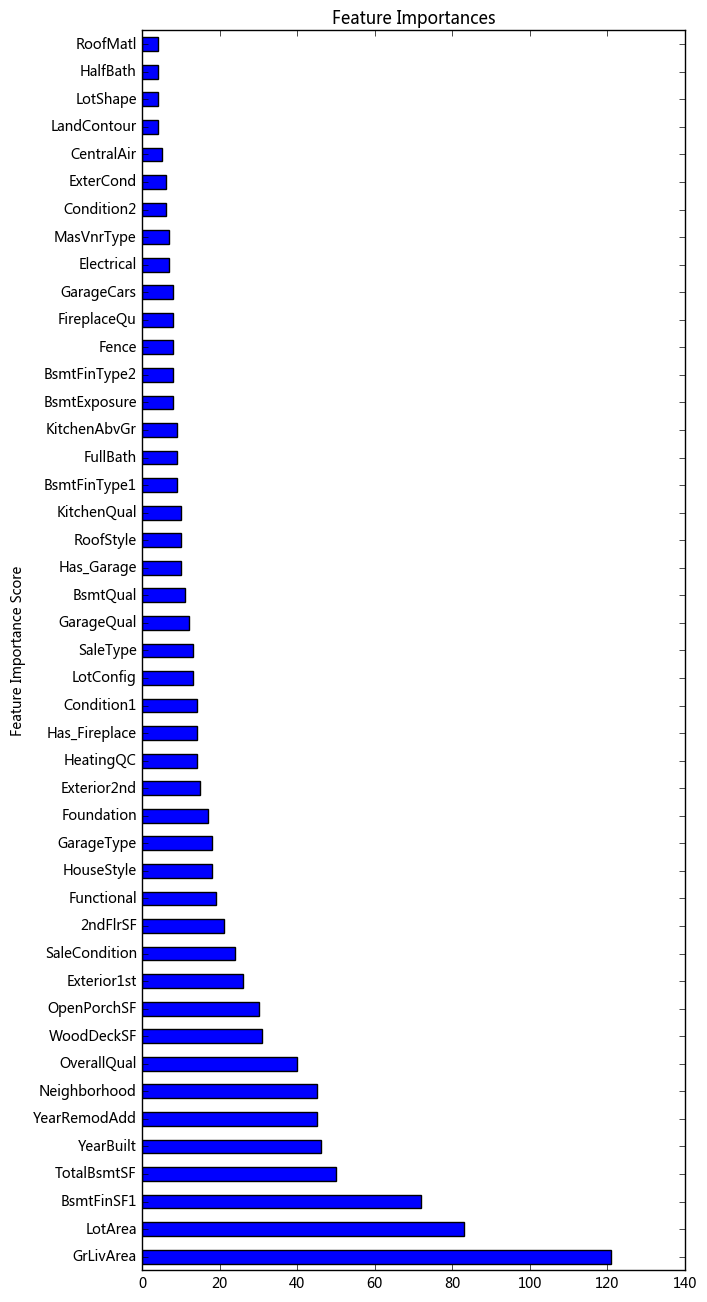

In [26]:
xgb_model = xgb.XGBRegressor(max_depth=4, learning_rate=0.1, n_estimators=100,
                             silent=False, objective='reg:linear', subsample=0.8,
                             colsample_bytree=0.8, gamma=0, min_child_weight = 1,
                             scale_pos_weight=1, seed=27)

modelfit(xgb_model, feature_names, X_train, y_train, X_test, y_test)
plt.show()

In [27]:
xgb_model = xgb.XGBRegressor(max_depth=2, learning_rate=0.1, n_estimators=100,\
                             silent=False, objective='reg:linear', subsample=0.8,\
                             colsample_bytree=0.75, gamma=0, min_child_weight = 6,\
                             scale_pos_weight=1, seed=27)

params1 = {
 'max_depth':np.array(range(3,10,2)),
 'min_child_weight':np.array(range(1,6,2))
}
search = ModelParamSearch(xgb_model, params1, X_train, y_train)


grid_scores
mean: 0.89704, std: 0.01197, params: {'min_child_weight': 1, 'max_depth': 3}
mean: 0.89405, std: 0.01139, params: {'min_child_weight': 3, 'max_depth': 3}
mean: 0.89546, std: 0.01071, params: {'min_child_weight': 5, 'max_depth': 3}
mean: 0.89376, std: 0.01161, params: {'min_child_weight': 1, 'max_depth': 5}
mean: 0.89425, std: 0.01226, params: {'min_child_weight': 3, 'max_depth': 5}
mean: 0.89531, std: 0.00975, params: {'min_child_weight': 5, 'max_depth': 5}
mean: 0.89361, std: 0.01223, params: {'min_child_weight': 1, 'max_depth': 7}
mean: 0.89468, std: 0.01054, params: {'min_child_weight': 3, 'max_depth': 7}
mean: 0.89429, std: 0.01136, params: {'min_child_weight': 5, 'max_depth': 7}
mean: 0.89162, std: 0.01116, params: {'min_child_weight': 1, 'max_depth': 9}
mean: 0.89207, std: 0.01034, params: {'min_child_weight': 3, 'max_depth': 9}
mean: 0.89440, std: 0.01268, params: {'min_child_weight': 5, 'max_depth': 9}

best_params
{'min_child_weight': 1, 'max_depth': 3}

best_scor

In [28]:
params = {
 'max_depth':[2, 3, 4],
 'min_child_weight':[1, 2, 3]
}
search2 = ModelParamSearch(xgb_model, params, X_train, y_train)

# 0.8959456941803028
# 0.8938496041827715


grid_scores
mean: 0.89155, std: 0.01139, params: {'min_child_weight': 1, 'max_depth': 2}
mean: 0.89168, std: 0.01295, params: {'min_child_weight': 2, 'max_depth': 2}
mean: 0.88904, std: 0.01246, params: {'min_child_weight': 3, 'max_depth': 2}
mean: 0.89704, std: 0.01197, params: {'min_child_weight': 1, 'max_depth': 3}
mean: 0.89719, std: 0.01392, params: {'min_child_weight': 2, 'max_depth': 3}
mean: 0.89405, std: 0.01139, params: {'min_child_weight': 3, 'max_depth': 3}
mean: 0.89437, std: 0.01310, params: {'min_child_weight': 1, 'max_depth': 4}
mean: 0.89945, std: 0.01166, params: {'min_child_weight': 2, 'max_depth': 4}
mean: 0.89531, std: 0.01219, params: {'min_child_weight': 3, 'max_depth': 4}

best_params
{'min_child_weight': 2, 'max_depth': 4}

best_score
0.8994528986489737


In [29]:
xgb_model = xgb.XGBRegressor(max_depth=4, learning_rate=0.1, n_estimators=100,\
                             silent=False, objective='reg:linear', subsample=0.55,\
                             colsample_bytree=0.7, gamma=0, min_child_weight = 2,\
                             scale_pos_weight=1, seed=27)

param4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

search4 = ModelParamSearch(xgb_model, param4, X_train, y_train)

# best_params
# {'colsample_bytree': 0.7, 'subsample': 0.7}

# best_score
# 0.9001576485029655


grid_scores
mean: 0.89883, std: 0.01379, params: {'colsample_bytree': 0.6, 'subsample': 0.6}
mean: 0.90012, std: 0.01264, params: {'colsample_bytree': 0.6, 'subsample': 0.7}
mean: 0.89725, std: 0.01483, params: {'colsample_bytree': 0.6, 'subsample': 0.8}
mean: 0.89645, std: 0.01783, params: {'colsample_bytree': 0.6, 'subsample': 0.9}
mean: 0.90106, std: 0.01421, params: {'colsample_bytree': 0.7, 'subsample': 0.6}
mean: 0.89793, std: 0.01679, params: {'colsample_bytree': 0.7, 'subsample': 0.7}
mean: 0.89672, std: 0.01671, params: {'colsample_bytree': 0.7, 'subsample': 0.8}
mean: 0.89590, std: 0.01873, params: {'colsample_bytree': 0.7, 'subsample': 0.9}
mean: 0.89707, std: 0.01535, params: {'colsample_bytree': 0.8, 'subsample': 0.6}
mean: 0.89696, std: 0.01518, params: {'colsample_bytree': 0.8, 'subsample': 0.7}
mean: 0.89643, std: 0.01540, params: {'colsample_bytree': 0.8, 'subsample': 0.8}
mean: 0.89364, std: 0.01888, params: {'colsample_bytree': 0.8, 'subsample': 0.9}
mean: 0.89697, 

In [30]:
xgb_model = xgb.XGBRegressor(max_depth=4, learning_rate=0.1, n_estimators=100,\
                             silent=False, objective='reg:linear', subsample=0.6,\
                             colsample_bytree=0.7, gamma=0, min_child_weight = 2,\
                             scale_pos_weight=1, seed=27)

param5 = {
    'colsample_bytree':[i/100.0 for i in range(65,80,5)],
    'subsample':[i/100.0 for i in range(55,70,5)]
 
}

search5 = ModelParamSearch(xgb_model, param5, X_train, y_train)


# best_params
# {'colsample_bytree': 0.65, 'subsample': 0.65}

# best_score
# 0.9007344923004951


grid_scores
mean: 0.89767, std: 0.01259, params: {'colsample_bytree': 0.65, 'subsample': 0.55}
mean: 0.89997, std: 0.01401, params: {'colsample_bytree': 0.65, 'subsample': 0.6}
mean: 0.90088, std: 0.01434, params: {'colsample_bytree': 0.65, 'subsample': 0.65}
mean: 0.89673, std: 0.01113, params: {'colsample_bytree': 0.7, 'subsample': 0.55}
mean: 0.90106, std: 0.01421, params: {'colsample_bytree': 0.7, 'subsample': 0.6}
mean: 0.89715, std: 0.01744, params: {'colsample_bytree': 0.7, 'subsample': 0.65}
mean: 0.89361, std: 0.01314, params: {'colsample_bytree': 0.75, 'subsample': 0.55}
mean: 0.89714, std: 0.01505, params: {'colsample_bytree': 0.75, 'subsample': 0.6}
mean: 0.89924, std: 0.01219, params: {'colsample_bytree': 0.75, 'subsample': 0.65}

best_params
{'colsample_bytree': 0.7, 'subsample': 0.6}

best_score
0.90105852610176


In [31]:
xgb_model = xgb.XGBRegressor(max_depth=4, learning_rate=0.1, n_estimators=100,\
                             silent=False, objective='reg:linear', subsample=0.6,\
                             colsample_bytree=0.7, gamma=0, min_child_weight = 2,\
                             scale_pos_weight=1, seed=27)

param6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

search6 = ModelParamSearch(xgb_model, param6, X_train, y_train)



grid_scores
mean: 0.90106, std: 0.01421, params: {'reg_alpha': 1e-05}
mean: 0.89892, std: 0.01375, params: {'reg_alpha': 0.01}
mean: 0.90039, std: 0.01293, params: {'reg_alpha': 0.1}
mean: 0.88585, std: 0.01450, params: {'reg_alpha': 1}
mean: -0.20214, std: 0.12844, params: {'reg_alpha': 100}

best_params
{'reg_alpha': 1e-05}

best_score
0.901058426019126


In [32]:
param7 = {
 'reg_alpha':[1e-07, 1e-05, 1e-03]
}

search7 = ModelParamSearch(xgb_model, param7, X_train, y_train)


# best_params
# {'reg_alpha': 1.1}

# best_score
# 0.9009523929423489


grid_scores
mean: 0.90106, std: 0.01421, params: {'reg_alpha': 1e-07}
mean: 0.90106, std: 0.01421, params: {'reg_alpha': 1e-05}
mean: 0.90083, std: 0.01400, params: {'reg_alpha': 0.001}

best_params
{'reg_alpha': 1e-07}

best_score
0.9010585457793528



Model Report
RMSE : 0.02021


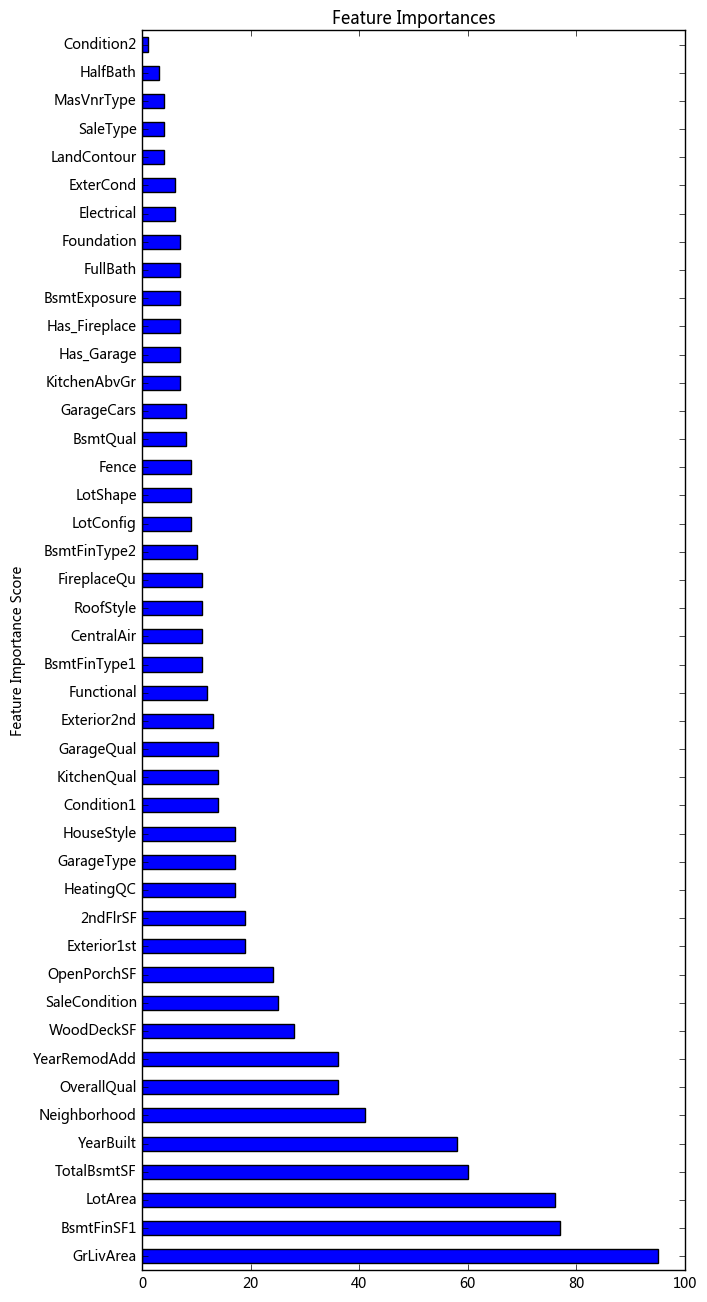

In [34]:
xgb_model = xgb.XGBRegressor(max_depth=4, learning_rate=0.1, n_estimators=100,\
                             silent=False, objective='reg:linear', subsample=0.6,\
                             colsample_bytree=0.7, gamma=0, min_child_weight = 2,\
                             scale_pos_weight=1, seed=27, reg_alpha=1e-07)

modelfit(xgb_model, feature_names, X_train, y_train, X_test, y_test)
plt.show()

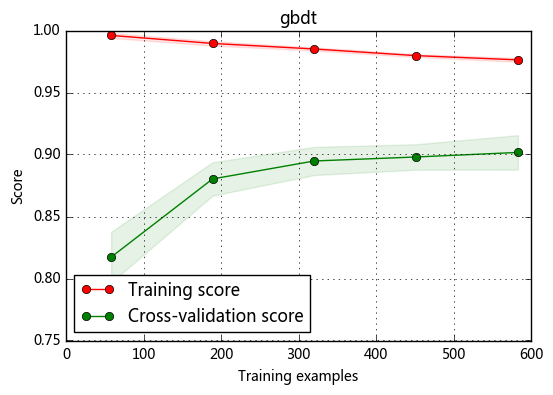

In [39]:
#gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, seed=0, missing=Nonemax_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear', booster='gbtree', nthread=-1, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, seed=0, missing=None
xgb_model = xgb.XGBRegressor(max_depth=4, learning_rate=0.01, n_estimators=1000,\
                             silent=False, objective='reg:linear', subsample=0.6,\
                             colsample_bytree=0.7, gamma=0, min_child_weight = 2,\
                             scale_pos_weight=1, seed=27, reg_alpha=1e-07)
plot_learning_curve(xgb_model, 'gbdt', X_train, y_train, cv=5)
plt.show()

In [40]:
xgb_model.fit(X_train, y_train)
xgb_model.score(X_test, y_test)

0.87604668363395155

In [45]:
xgb_model.fit(X_train_df.values, y_train_df['SalePrice'].values)


XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=2, missing=None, n_estimators=1000, nthread=-1,
       objective='reg:linear', reg_alpha=1e-07, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=False, subsample=0.6)

In [31]:
0.87256074767322089
0.86215552690396724
0.86209053019833237
0.84963578857989486
0.85519185040271417
0.87586527403706282
0.88027425879399812
0.87161084260404043

0.8716108426040404

In [41]:
X_train_df.columns

Index(['GrLivArea', 'BsmtFinSF1', 'Has_Fireplace', 'KitchenAbvGr', 'Fence',
       'SaleType', 'MasVnrType', 'ExterCond', 'Condition2', 'CentralAir',
       'Foundation', 'BsmtFinType1', 'RoofMatl', 'HeatingQC', 'Has_Garage',
       'LotArea', 'OverallQual', 'GarageQual', 'Electrical', 'TotalBsmtSF',
       'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1',
       'HouseStyle', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'Exterior1st', 'Exterior2nd', 'Has_Bsmt', 'BsmtQual', 'BsmtExposure',
       'BsmtFinType2', '2ndFlrSF', 'HalfBath', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF',
       'SaleCondition'],
      dtype='object')

In [46]:
y_predict = xgb_model.predict(X_test_df.values)

In [47]:
y_predict_df = pd.DataFrame(y_predict, index=X_test_df.index)
y_predict_df = y_predict_df.rename(columns={0:'SalePrice'})

In [48]:
y_predict_df['SalePrice'] = np.expm1(y_predict_df['SalePrice'])
y_predict_df.to_csv('../data/online/predict.csv', header = True, index=True)